# **Introduction**

In [4]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# **Organizing Data**

In [5]:
train_label = pd.read_csv(r"C:\Users\baliy\Downloads\Medical Analysis Expert System\Medical Analysis Expert System\glauoma\glaucoma.csv")
y_train = train_label['Glaucoma']
train_label.head()

,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0


# **Looking at the Data**

I first tried some manual data augmentation and preprocessing.

In [6]:
from numpy import asarray

from PIL import Image
# load the image
image = Image.open('/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Positive/613.jpg')
print(image.format)
print(image.mode)
print(image.size)
# show the image
image.show()
pixels = asarray(image)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Positive/613.jpg'

In [ ]:

# global centering

# calculate global mean
mean = pixels.mean()
print('Mean: %.3f' % mean)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# global centering of pixels
pixels = pixels - mean

mean = pixels.mean()
print('Mean: %.3f' % mean)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
print(pixels)


# pixel normalization
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# convert from integers to floats
pixels = pixels.astype('float32')
# normalize to the range 0-1
pixels /= 255.0
mean = pixels.mean()
print('pixel mean = ', mean)

# confirm the normalization
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
print(pixels)

Mean: 73.462
Min: 0.000, Max: 255.000
Mean: 0.000
Min: -73.462, Max: 181.538
[[[-71.46201356 -71.46201356 -73.46201356]
  [-71.46201356 -71.46201356 -73.46201356]
  [-71.46201356 -71.46201356 -73.46201356]
  ...
  [-72.46201356 -72.46201356 -73.46201356]
  [-72.46201356 -72.46201356 -73.46201356]
  [-72.46201356 -72.46201356 -73.46201356]]

 [[-71.46201356 -71.46201356 -73.46201356]
  [-71.46201356 -71.46201356 -73.46201356]
  [-71.46201356 -71.46201356 -73.46201356]
  ...
  [-72.46201356 -72.46201356 -73.46201356]
  [-72.46201356 -72.46201356 -73.46201356]
  [-72.46201356 -72.46201356 -73.46201356]]

 [[-71.46201356 -71.46201356 -73.46201356]
  [-71.46201356 -71.46201356 -73.46201356]
  [-71.46201356 -71.46201356 -73.46201356]
  ...
  [-72.46201356 -72.46201356 -73.46201356]
  [-72.46201356 -72.46201356 -73.46201356]
  [-72.46201356 -72.46201356 -73.46201356]]

 ...

 [[-73.46201356 -73.46201356 -73.46201356]
  [-73.46201356 -73.46201356 -73.46201356]
  [-73.46201356 -73.46201356 -73.

**Visulization**

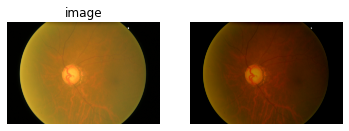

In [ ]:
import matplotlib.pyplot as plt
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(image)
ax0.axis('off')
ax0.set_title('image')
ax1.imshow(pixels)
ax1.axis('off')
plt.show()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# **Modeling**

In [ ]:
TRAIN_DIR = '/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train'

TEST_DIR = '/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'

# **ResNet50**

In [ ]:
from keras.applications import *
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model 
from keras.optimizers import SGD, Adam
from keras.callbacks import TensorBoard
import keras
import matplotlib.pyplot as plt

HEIGHT = 300
WIDTH = 300

BATCH_SIZE = 8
class_list = ["class_1", "class_2"]
FC_LAYERS = [1024, 512, 256]
dropout = 0.5
NUM_EPOCHS = 20
BATCH_SIZE = 8

def build_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        print(fc)
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)
    preditions = Dense(num_classes, activation='softmax')(x)
    finetune_model = Model(inputs = base_model.input, outputs = preditions)
    return finetune_model

base_model_1 = VGG16(weights = None,
                       include_top = False,
                       input_shape = (HEIGHT, WIDTH, 3))

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 90,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.1,)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                  rotation_range = 90,
                                  horizontal_flip = True,
                                  vertical_flip = False)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size = (HEIGHT, WIDTH),
                                                    batch_size = BATCH_SIZE)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size = (HEIGHT, WIDTH),
                                                  batch_size = BATCH_SIZE)




vgg16_model = build_model(base_model_1,
                                      dropout = dropout,
                                      fc_layers = FC_LAYERS,
                                      num_classes = len(class_list))

adam = Adam()
vgg16_model.compile(adam, loss="binary_crossentropy", metrics=["accuracy"])

filepath = "./checkpoints" + "Vgg16" + "_model_weights.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor = ["acc"], verbose= 1, mode = "max")
# cb=TensorBoard(log_dir=("/home/ubuntu/"))
callbacks_list = [checkpoint]

print(train_generator.class_indices)

vgg16_model.summary()

Found 520 images belonging to 2 classes.
Found 130 images belonging to 2 classes.
1024
512
256
{'Glaucoma_Negative': 0, 'Glaucoma_Positive': 1}
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 1

In [ ]:
history = vgg16_model.fit_generator(generator = train_generator, epochs = 5, steps_per_epoch = 30, 
                                       shuffle = True, validation_data = test_generator)


Epoch 1/5
30/30 [==============================] - 38s 1s/step - loss: 3.6846 - accuracy: 0.7500 - val_loss: 4.0112 - val_accuracy: 0.7385
Epoch 2/5
30/30 [==============================] - 35s 1s/step - loss: 3.7704 - accuracy: 0.7542 - val_loss: 4.0112 - val_accuracy: 0.7385
Epoch 3/5
30/30 [==============================] - 34s 1s/step - loss: 3.8982 - accuracy: 0.7458 - val_loss: 4.0112 - val_accuracy: 0.7385
Epoch 4/5
30/30 [==============================] - 34s 1s/step - loss: 4.4733 - accuracy: 0.7083 - val_loss: 4.0112 - val_accuracy: 0.7385
Epoch 5/5
30/30 [==============================] - 33s 1s/step - loss: 4.2177 - accuracy: 0.7250 - val_loss: 4.0112 - val_accuracy: 0.7385


In [ ]:
vgg16_model.save("model.h5")

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

In [ ]:
Y_pred = vgg16_model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
print(confusion_matrix(test_generator.classes, y_pred))

Confusion Matrix
[[96  0]
 [34  0]]


In [ ]:
print("ACCURACY SCORE  :",accuracy_score(test_generator.classes,y_pred))

ACCURACY SCORE  : 0.7384615384615385


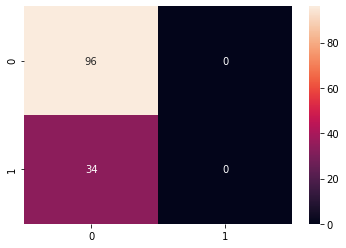

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [ ]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/model.h5')